In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from sklearn import decomposition
from scipy import stats
from sklearn import cluster

matplotlib.style.use('fivethirtyeight')
matplotlib.rcParams['font.size'] = 12
matplotlib.rcParams['figure.figsize'] = (10, 10)

In [2]:
# Load the data
train = pd.read_csv('train.csv')

train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [3]:
train.shape

(1458644, 11)

In [4]:
# remove outliters
lat = np.array(list(train['pickup_latitude']) + list(train['dropoff_latitude']))
long = np.array(list(train['pickup_longitude']) + list(train['dropoff_longitude']))

long_limits = [np.percentile(long, 0.3), np.percentile(long, 99.7)]
lat_limits = [np.percentile(lat, 0.3), np.percentile(lat, 99.7)]
dur_limits = [np.percentile(train['trip_duration'], 0.4), np.percentile(train['trip_duration'], 99.6)]

train = train[(train['pickup_latitude'] >= lat_limits[0]) & (train['pickup_latitude'] <= lat_limits[1])]
train = train[(train['dropoff_latitude'] >= lat_limits[0]) & (train['dropoff_latitude'] <= lat_limits[1])]
train = train[(train['pickup_longitude'] >= long_limits[0]) & (train['pickup_longitude'] <= long_limits[1])]
train = train[(train['dropoff_longitude'] >= long_limits[0]) & (train['dropoff_longitude'] <= long_limits[1])]
train = train[(train['trip_duration'] >= dur_limits[0]) & (train['trip_duration'] <= dur_limits[1])]
train = train.reset_index(drop=True)

allLat = np.array(list(train['pickup_latitude']) + list(train['dropoff_latitude']))
allLong = np.array(list(train['pickup_longitude']) + list(train['dropoff_longitude']))

In [5]:
train.shape

(1418863, 11)

In [6]:
# convert to sensible units
median_lat = np.percentile(allLat, 50)
median_long = np.percentile(allLong, 50)

lat_multiplier = 111.32
long_multiplier = np.cos(median_lat*(np.pi/180.0)) * 111.32

train['duration [min]'] = train['trip_duration'] / 60.0
train['src lat [km]'] = lat_multiplier * (train['pickup_latitude'] - median_lat)
train['src long [km]'] = long_multiplier * (train['pickup_longitude'] - median_long)
train['dst lat [km]'] = lat_multiplier * (train['dropoff_latitude'] - median_lat)
train['dst long [km]'] = long_multiplier * (train['dropoff_longitude'] - median_long)

all_lat = np.array(list(train['src lat [km]']) + list(train['dst lat [km]']))
all_long = np.array(list(train['src long [km]']) + list(train['dst long [km]']))

Text(0.5, 0, 'longitude [km]')

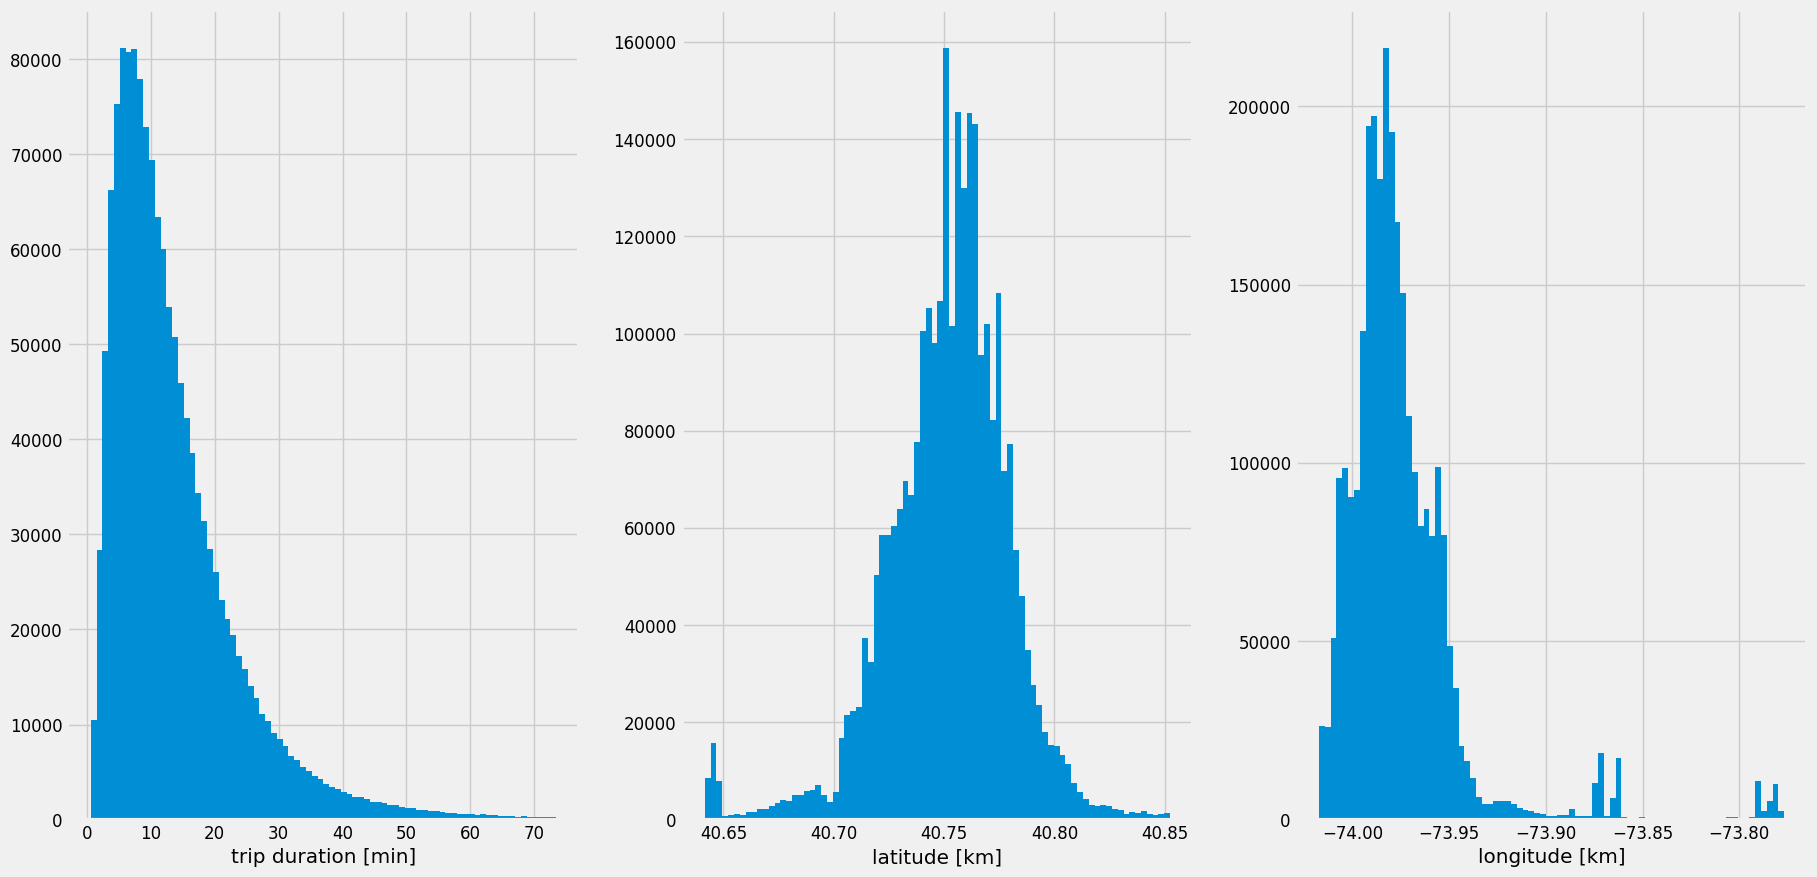

In [7]:
# Plot the data
fig, ax = plt.subplots(1, 3, figsize=(20,10))
ax[0].hist(train['duration [min]'], 80)
ax[0].set_xlabel('trip duration [min]')
ax[1].hist(allLat, 80)
ax[1].set_xlabel('latitude [km]')
ax[2].hist(allLong, 80)
ax[2].set_xlabel('longitude [km]')

Text(0.5, 1.0, 'Log Duration vs Aerial trip distance')

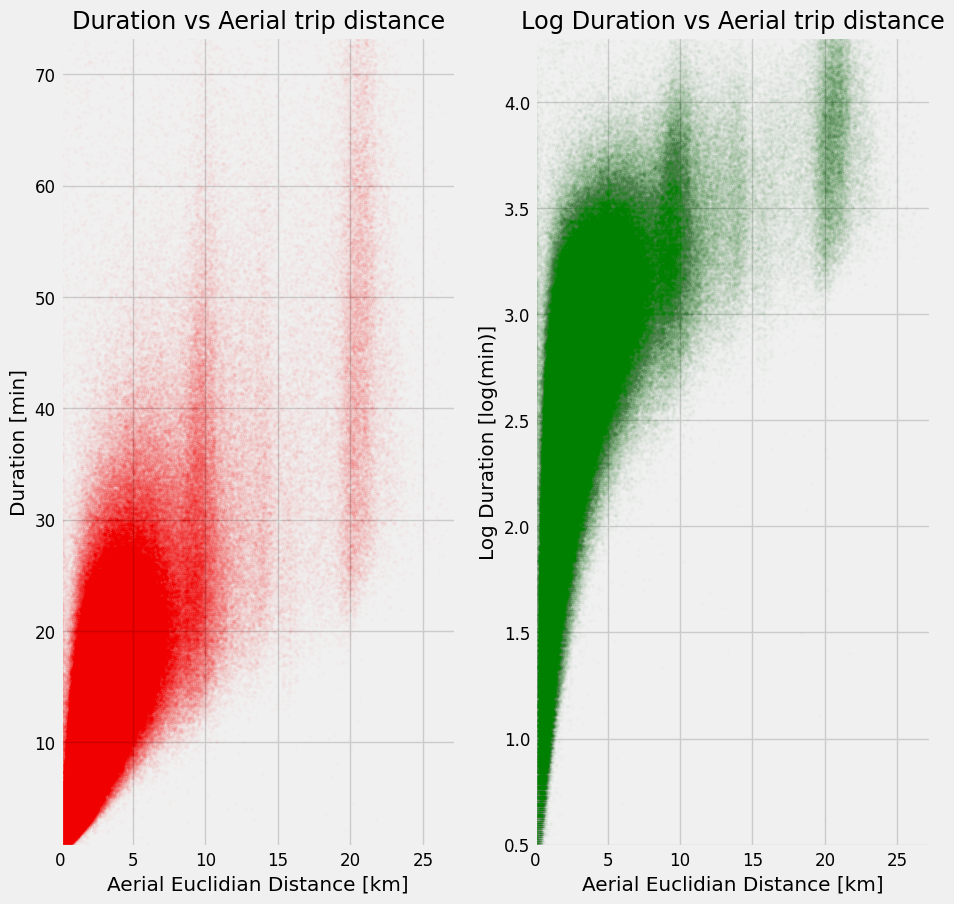

In [8]:
# scatter plot of trip duration vs aerial distance between pickup and dropoff
train['log duration'] = np.log1p(train['duration [min]'])
train['euclidian distance'] = np.sqrt((train['src lat [km]'] - train['dst lat [km]'])**2 +
                                          (train['src long [km]'] - train['dst long [km]'])**2)

fig, ax = plt.subplots(1, 2, figsize=(10,10))
ax[0].scatter(train['euclidian distance'], train['duration [min]'], c='r', s=5, alpha=0.01)
ax[0].set_xlabel('Aerial Euclidian Distance [km]')
ax[0].set_ylabel('Duration [min]')
ax[0].set_xlim(train['euclidian distance'].min(), train['euclidian distance'].max())
ax[0].set_ylim(train['duration [min]'].min(), train['duration [min]'].max())
ax[0].set_title('Duration vs Aerial trip distance')

ax[1].scatter(train['euclidian distance'], train['log duration'], c='g', s=5, alpha=0.01)
ax[1].set_xlabel('Aerial Euclidian Distance [km]')
ax[1].set_ylabel('Log Duration [log(min)]')
ax[1].set_xlim(train['euclidian distance'].min(), train['euclidian distance'].max())
ax[1].set_ylim(train['log duration'].min(), train['log duration'].max())
ax[1].set_title('Log Duration vs Aerial trip distance')

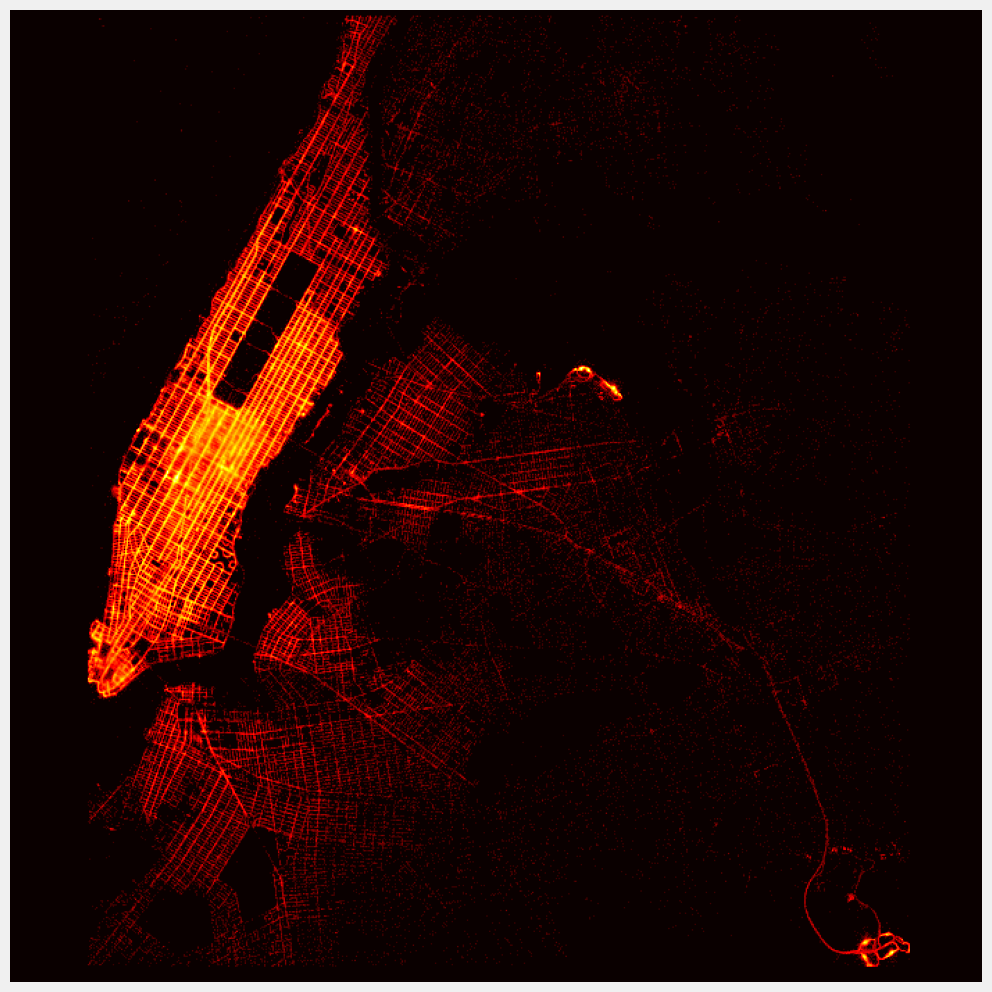

In [9]:
# plot spatial distribution of pickup and dropoff points
image_size = (700, 700)
long_range = [-5, 19]
lat_range = [-13, 11]

all_lat_inds = image_size[0] - (image_size[0] * (all_lat - lat_range[0]) / (lat_range[1] - lat_range[0]) ).astype(int)
all_long_inds = (image_size[1] * (all_long - long_range[0]) / (long_range[1] - long_range[0]) ).astype(int)

location_density_image = np.zeros(image_size)
for lat_ind, long_ind in zip(all_lat_inds, all_long_inds):
    location_density_image[lat_ind, long_ind] += 1

fig, ax = plt.subplots(1, 1, figsize=(12,12))
ax.imshow(np.log(location_density_image+1), cmap='hot')
ax.set_axis_off()

(-0.5, 479.5, 719.5, -0.5)

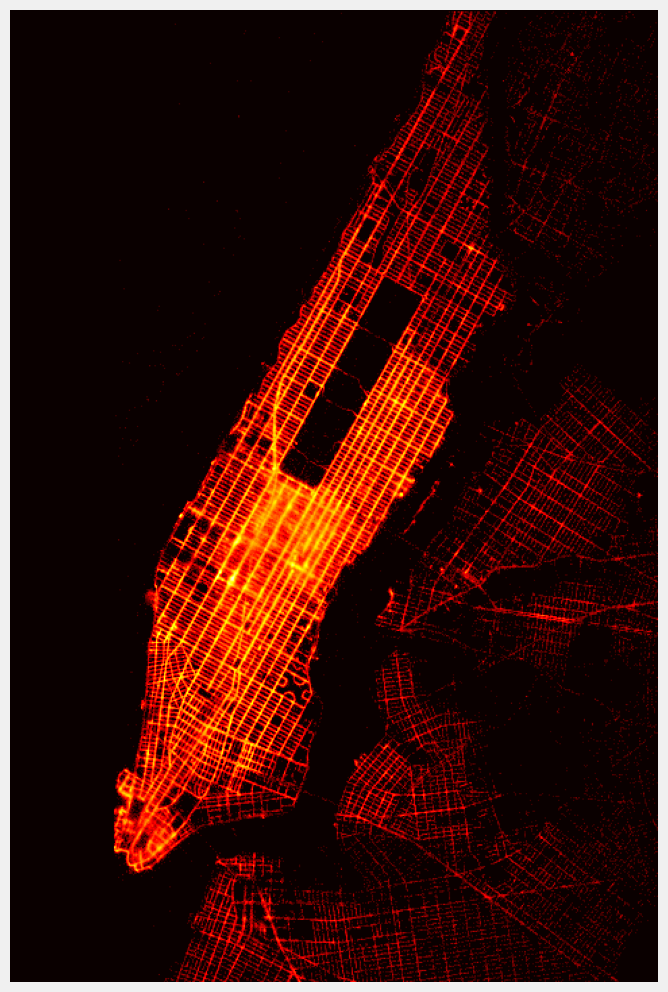

In [14]:
# zoom in on Manhattan
image_size_man = (720, 480)
lat_range_man = [-8, 10]
long_range_man = [-5, 7]

ind_to_keep = ((all_lat > lat_range_man[0]) & 
               (all_lat < lat_range_man[1])) & \
              ((all_long > long_range_man[0]) &  
               (all_long < long_range_man[1]))
all_lat_man, all_long_man = all_lat[ind_to_keep], all_long[ind_to_keep]

lat_inds_man = image_size_man[0] - np.int_(image_size_man[0]*((all_lat_man-lat_range_man[0])/(lat_range_man[1]-lat_range_man[0])))
long_inds_man = np.int_(image_size_man[1]*( (all_long_man-long_range_man[0])/ (long_range_man[1]-long_range_man[0])))

# Create 2D array for heatmap
heatmap_inds = np.zeros((image_size_man[0], image_size_man[1]))

for lat_ind, long_ind in zip(lat_inds_man, long_inds_man):
    if (lat_ind < image_size_man[0] and 
        long_ind < image_size_man[1]):
        heatmap_inds[int(lat_ind), int(long_ind)] += 1

location_density_image_man = np.zeros((image_size_man[0], image_size_man[1]))
location_density_image_man[:, :] = heatmap_inds.copy()

# Plot the heatmap as before
fig, ax = plt.subplots(1, 1, figsize=(12,12))
plt.imshow(np.log(location_density_image_man+1), cmap='hot')
plt.axis('off')

In [17]:
# create some new features
pickup_time = pd.to_datetime(train['pickup_datetime'])

train['src hour of day'] = (pickup_time.dt.hour + pickup_time.dt.minute/60.0)
train['dst hour of day'] = train['src hour of day'] + train['duration [min]']/60.0

train['day of week'] = pickup_time.dt.weekday
train['hour of week'] = train['day of week']*24 + train['src hour of day']

train['month of year'] = pickup_time.dt.month
train['day of year'] = pickup_time.dt.dayofyear
train['week of year'] = pickup_time.dt.isocalendar().week.astype(int)
train['hour of year'] = train['day of year']*24 + train['src hour of day']

In [18]:
train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,log duration,euclidian distance,src hour of day,dst hour of day,day of week,hour of week,month of year,day of year,week of year,hour of year
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,...,2.149822,1.500473,17.400000,17.526389,0,17.400000,3,74,11,1793.400000
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,...,2.489065,1.807114,0.716667,0.900833,6,144.716667,6,164,23,3936.716667
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,...,3.594569,6.392077,11.583333,12.173333,1,35.583333,1,19,3,467.583333
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,...,2.098018,1.487155,19.533333,19.652500,2,67.533333,4,97,14,2347.533333
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,...,2.110213,1.189925,13.500000,13.620833,5,133.500000,3,86,12,2077.500000


(0.0, 81.0)

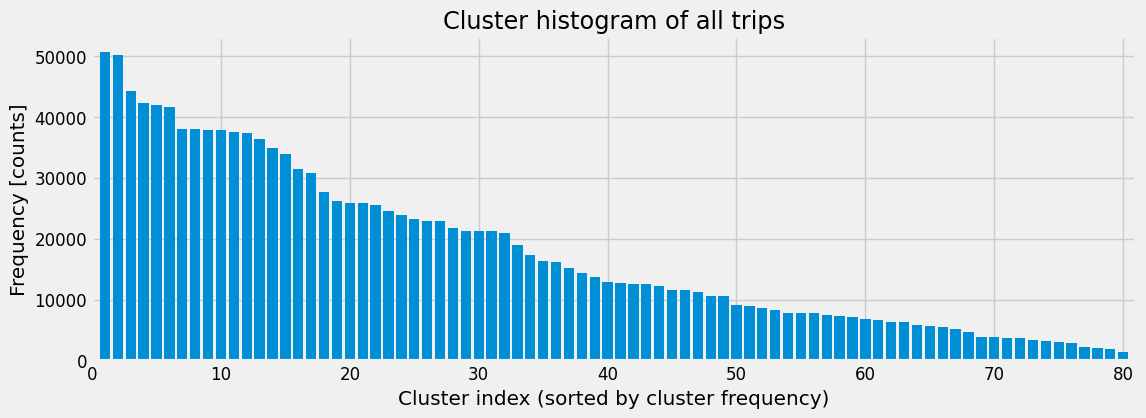

In [19]:
# plot cluster map
trip_attributes = np.array(train.loc[:, ['src lat [km]', 'src long [km]', 'dst lat [km]', 'dst long [km]', 'duration [min]']])
mean_trip_attributes = trip_attributes.mean(axis=0)
std_trip_attributes = trip_attributes.std(axis=0)
trip_attributes = stats.zscore(trip_attributes, axis=0)

num_clusters = 80
kmeans = cluster.MiniBatchKMeans(n_clusters=num_clusters, batch_size=120000, n_init=100, random_state=42)
cluster_inds = kmeans.fit_predict(trip_attributes)

cluster_total, _ = np.histogram(cluster_inds, bins=num_clusters)
sorted_clusters = np.flipud(np.argsort(cluster_total))

plt.figure(figsize=(12,4))
plt.title('Cluster histogram of all trips')
plt.bar(range(1, num_clusters+1), cluster_total[sorted_clusters])
plt.ylabel('Frequency [counts]')
plt.xlabel('Cluster index (sorted by cluster frequency)')
plt.xlim(0, num_clusters+1)

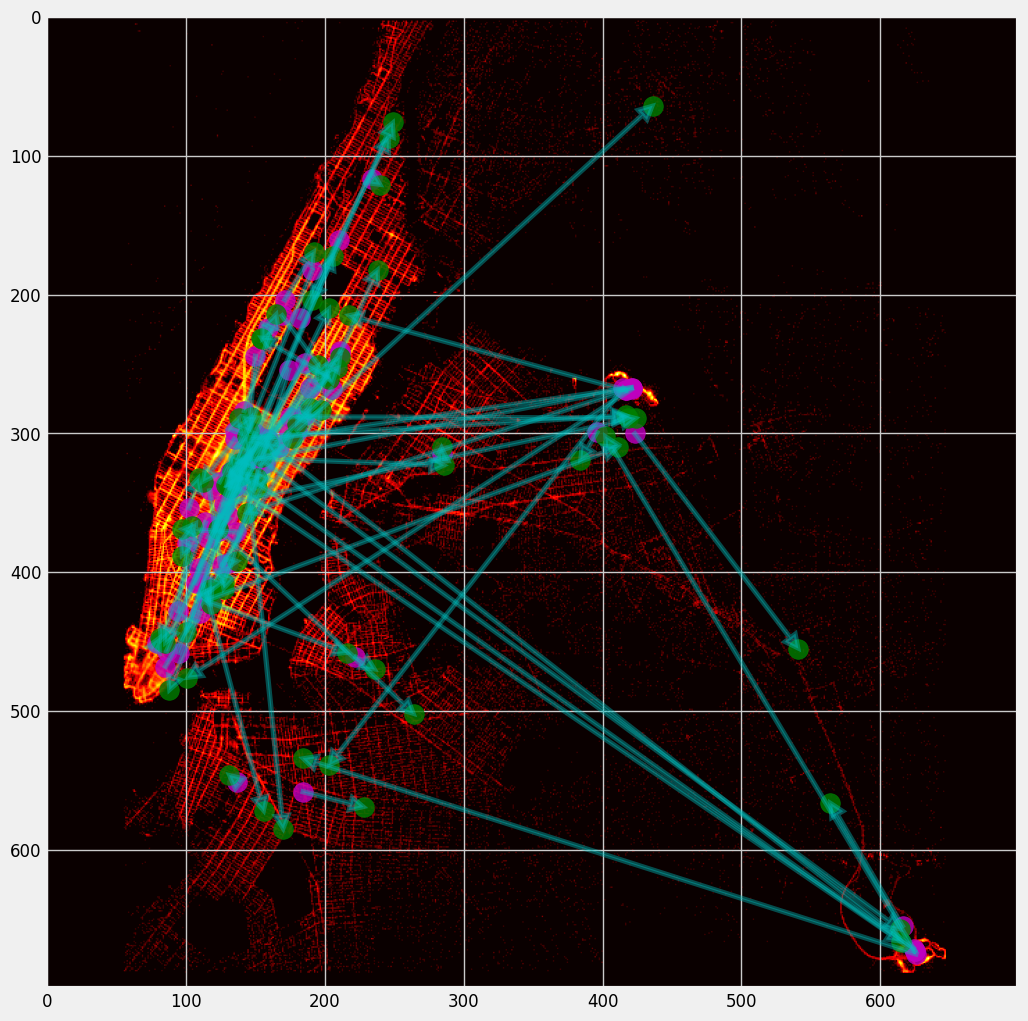

In [21]:
# show trips on map
def covert_to_img_coords(lat, long, lat_range, long_range, image_size):
    lat_inds = image_size[0] - (image_size[0] * (lat - lat_range[0]) / (lat_range[1] - lat_range[0]) ).astype(int)
    long_inds = (image_size[1] * (long - long_range[0]) / (long_range[1] - long_range[0]) ).astype(int)
    return lat_inds, long_inds

template_trips = kmeans.cluster_centers_ * np.tile(std_trip_attributes, (num_clusters, 1)) + np.tile(mean_trip_attributes, (num_clusters, 1))

src_coords = template_trips[:, :2]
dst_coords = template_trips[:, 2:4]

src_img_coords = covert_to_img_coords(src_coords[:, 0], src_coords[:,1], lat_range, long_range, image_size)
dst_img_coords = covert_to_img_coords(dst_coords[:, 0], dst_coords[:,1], lat_range, long_range, image_size)

plt.figure(figsize=(12,12))
plt.imshow(np.log(location_density_image+1), cmap='hot')
plt.grid('off')
plt.scatter(src_img_coords[1], src_img_coords[0], c='m', s=200, alpha=0.8)
plt.scatter(dst_img_coords[1], dst_img_coords[0], c='g', s=200, alpha=0.8)

for i in range(len(src_img_coords[0])):
    plt.arrow(src_img_coords[1][i], src_img_coords[0][i], dst_img_coords[1][i]-src_img_coords[1][i], dst_img_coords[0][i]-src_img_coords[0][i], 
              edgecolor='c', facecolor='c', width=0.8, alpha=0.4, lw=3, head_width=10.0, head_length=10.0, length_includes_head=True)